In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import cv2
import glob
from tensorflow.keras.preprocessing import image_dataset_from_directory


CWD_PATH = os.getcwd()
MODEL_PATH = os.path.join(CWD_PATH, 'train_models')
MODEL_NAME = 'CLOTH_BS64_EPOCH300_DROPOUT02'
MODEL_NAME_PATH = os.path.join(MODEL_PATH,MODEL_NAME)
SAVED_MODEL_PATH = os.path.join(MODEL_NAME_PATH, '{}_model'.format(MODEL_NAME))
SAVED_FINETUNE_MODEL_PATH = os.path.join(MODEL_NAME_PATH, '{}_finetune_model'.format(MODEL_NAME))
DATA_PATH = os.path.join(CWD_PATH, 'normal_vs_camouflage')



BATCH_SIZE = 64
IMG_SIZE = (224, 224)
SHAPE_SIZE = (224,224,3)
VALIDATION_SPLIT = 0.3
STEPS_PER_EPOCH = 1
initial_epochs = 300
fine_tune_epochs = 300
final_batch_size = 64
DROPU_OUT = 0.2
base_learning_rate = 0.0001
AUTOTUNE = tf.data.experimental.AUTOTUNE
if not os.path.exists(MODEL_NAME_PATH):
    os.mkdir(MODEL_NAME_PATH)

In [2]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1),
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
  ]
)

In [3]:
train_dataset = image_dataset_from_directory(DATA_PATH,
                                             shuffle=True,
                                             validation_split=VALIDATION_SPLIT,
                                             subset="training",
                                             seed=123,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(DATA_PATH,
                                                  shuffle=True,
                                                  validation_split=VALIDATION_SPLIT,
                                                  subset="validation",
                                                  seed=123,                                                  
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

class_names = train_dataset.class_names

print('classes ', class_names)

## take 1 / 5 batch for test data
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of training batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 15898 files belonging to 2 classes.
Using 11129 files for training.
Found 15898 files belonging to 2 classes.
Using 4769 files for validation.
classes  ['camouflage_clothes', 'normal_clothes']
Number of training batches: 174
Number of validation batches: 60
Number of test batches: 15


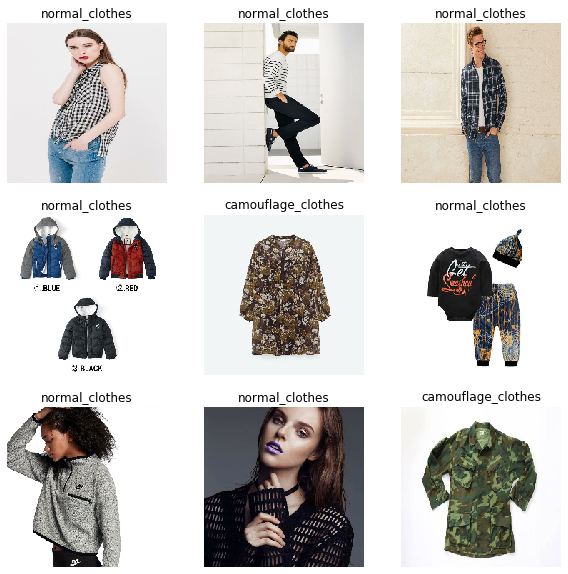

In [4]:
#visualize train data
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [5]:
# define callbacks
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(MODEL_NAME_PATH,"model_history_log.csv"), append=True)
check_point_filepath = os.path.join(MODEL_NAME_PATH,"check_point_model.h5")
check_point_filepath_finetune = os.path.join(MODEL_NAME_PATH,"check_point_model_finetune.h5")
checkpoint = tf.keras.callbacks.ModelCheckpoint(check_point_filepath, monitor='loss', verbose=1, save_freq='epoch', save_best_only=True, mode='min')
checkpoint_finetune = tf.keras.callbacks.ModelCheckpoint(check_point_filepath_finetune, monitor='loss', verbose=1, save_freq='epoch', save_best_only=True, mode='min')
earlyStop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5,min_delta=0.0)

normal_callbacks = [csv_logger,checkpoint,earlyStop]
finetune_callbacks = [csv_logger,checkpoint_finetune,earlyStop]


In [6]:
# define loss Object
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def get_optimizer(reduce_learning=False):
    if(reduce_learning):
        return tf.keras.optimizers.Adam(lr=base_learning_rate)
    else:
        return tf.keras.optimizers.Adam()

optimizer_finetune = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10)

In [7]:
base_model = tf.keras.applications.MobileNetV2(input_shape=SHAPE_SIZE, include_top=False, weights='imagenet')
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
#feature extraction
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [8]:
## data augmentation & drop out to overcome the overfit
 
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
#softmax set the Dense with number of classes
prediction_layer = tf.keras.layers.Dense(1)
inputs = tf.keras.Input(shape=SHAPE_SIZE)
x = data_augmentation(inputs)
#x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
if(DROPU_OUT > 0):
    x = tf.keras.layers.Dropout(DROPU_OUT)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs, name=MODEL_NAME)
model.summary()

Model: "CLOTH_BS64_EPOCH300_DROPOUT02"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_______________________

In [9]:
model.compile(optimizer=get_optimizer(),loss=loss_object,metrics=['accuracy'])

60/60 [==============================] - 23s 382ms/step - loss: 0.7101 - accuracy: 0.5366
initial loss: 0.71
initial accuracy: 0.54
Epoch 1/300
174/174 [==============================] - ETA: 0s - loss: 0.1712 - accuracy: 0.9280
Epoch 00001: loss improved from inf to 0.17125, saving model to /home/williamkhoo/Desktop/projects/github/flower_classification/train_models/CLOTH_BS64_EPOCH300_DROPOUT02/check_point_model.h5
174/174 [==============================] - 64s 370ms/step - loss: 0.1712 - accuracy: 0.9280 - val_loss: 0.0658 - val_accuracy: 0.9816
Epoch 2/300
174/174 [==============================] - ETA: 0s - loss: 0.0761 - accuracy: 0.9734
Epoch 00002: loss improved from 0.17125 to 0.07614, saving model to /home/williamkhoo/Desktop/projects/github/flower_classification/train_models/CLOTH_BS64_EPOCH300_DROPOUT02/check_point_model.h5
174/174 [==============================] - 14s 83ms/step - loss: 0.0761 - accuracy: 0.9734 - val_loss: 0.0515 - val_accuracy: 0.9853
Epoch 3/300
174/174

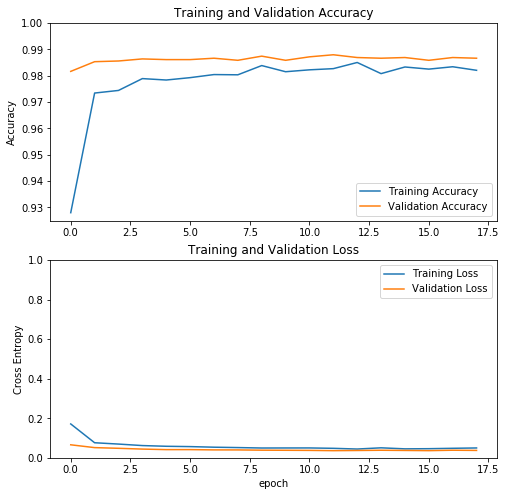

In [10]:
loss0, accuracy0 = model.evaluate(validation_dataset)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))


history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                   callbacks=normal_callbacks)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig(os.path.join(MODEL_NAME_PATH,'stats.png'))
tf.saved_model.save(model, SAVED_MODEL_PATH)

In [11]:
#evaluate model
loss2, accuracy2 = model.evaluate(test_dataset)
print('Test accuracy :', accuracy2)
print('Test Loss :', loss2)

15/15 [==============================] - 3s 193ms/step - loss: 0.0313 - accuracy: 0.9854
Test accuracy : 0.9854166507720947
Test Loss : 0.03127845749258995


Predictions:
 [0 1 1 0 1 1 0 1 0 1 1 0 1 1 1 0 1 1 1 0 0 0 1 0 0 1 0 1 1 1 1 1 0 0 0 0 1
 1 0 1 0 0 1 0 0 0 1 1 1 0 1 1 1 1 0 0 1 0 0 1 1 0 0 0]
Labels:
 [0 1 1 0 1 1 0 1 0 1 1 0 1 1 1 0 1 1 1 0 0 1 1 0 0 1 0 1 1 1 1 1 0 0 0 0 1
 1 0 1 0 0 1 0 0 0 1 1 1 0 1 1 1 1 0 0 1 0 0 1 1 0 0 0]


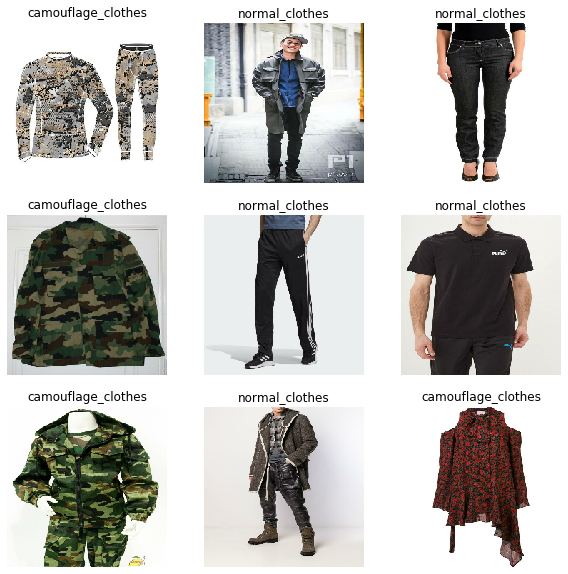

In [12]:
# visualize 
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [14]:
#fine tuning
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

model.compile(optimizer = optimizer_finetune,
              loss=loss_object, 
              metrics=['accuracy'])

model.summary()

establish_epoch = history.epoch[-1]
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         batch_size=final_batch_size,
                         validation_data=validation_dataset,
                         callbacks=finetune_callbacks)

#loss1, accuracy1 = model.evaluate(test_dataset)
#print('Test accuracy :', accuracy1)
#print('Test Loss :', loss1)
tf.saved_model.save(model, SAVED_FINETUNE_MODEL_PATH)

Number of layers in the base model:  155
Model: "CLOTH_BS64_EPOCH300_DROPOUT02"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,863,873
Non-traina

Epoch 35/600
174/174 [==============================] - ETA: 0s - loss: 0.0091 - accuracy: 0.9960
Epoch 00035: loss did not improve from 0.00653
174/174 [==============================] - 17s 100ms/step - loss: 0.0091 - accuracy: 0.9960 - val_loss: 0.0186 - val_accuracy: 0.9950
Epoch 36/600
174/174 [==============================] - ETA: 0s - loss: 0.0071 - accuracy: 0.9975
Epoch 00036: loss did not improve from 0.00653
174/174 [==============================] - 18s 101ms/step - loss: 0.0071 - accuracy: 0.9975 - val_loss: 0.0161 - val_accuracy: 0.9955
Epoch 37/600
174/174 [==============================] - ETA: 0s - loss: 0.0068 - accuracy: 0.9973
Epoch 00037: loss did not improve from 0.00653
174/174 [==============================] - 18s 101ms/step - loss: 0.0068 - accuracy: 0.9973 - val_loss: 0.0202 - val_accuracy: 0.9950
Epoch 38/600
174/174 [==============================] - ETA: 0s - loss: 0.0059 - accuracy: 0.9983
Epoch 00038: loss improved from 0.00653 to 0.00592, saving model 

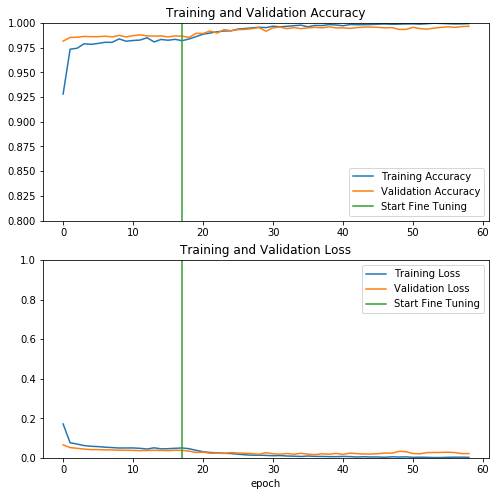

<Figure size 432x288 with 0 Axes>

In [15]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([establish_epoch,establish_epoch],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([establish_epoch,establish_epoch],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()
plt.savefig(os.path.join(MODEL_NAME_PATH,'stats_finetune.png'))

In [16]:
#evaluate finetune model
loss3, accuracy3 = model.evaluate(test_dataset)
print('Test accuracy :', accuracy3)
print('Test Loss :', loss3)

15/15 [==============================] - 3s 193ms/step - loss: 0.0084 - accuracy: 0.9969
Test accuracy : 0.996874988079071
Test Loss : 0.008391749113798141


In [28]:
model = tf.keras.models.load_model(SAVED_FINETUNE_MODEL_PATH)
#model = tf.keras.models.load_model(SAVED_MODEL_PATH)
test_images_dir = os.path.join(CWD_PATH, 'test_images')

In [25]:
def pred(image_path,target_size = (224, 224)):
    file_name = os.path.basename(os.path.basename(image_path))
    im = plt.imread(image_path)
    resize = cv2.resize(im,target_size)
    test_image = np.expand_dims(resize, axis=0)
    predictions = model.predict(test_image)
    score = predictions[0][0]
    predicted_class = 0 if score < 0.5 else 1

    print("{}, predict {}".format(file_name, class_names[predicted_class]))
    #return predictions_scores


def test_folder():
    lst = sorted(glob.glob("{}/*".format(test_images_dir)))
    i = 0
    print('getting folder {}, size: {}', test_images_dir, len(lst))
    for file in list(lst):
        pred(file)


In [26]:
test_folder()

getting folder {}, size: {} /home/williamkhoo/Desktop/projects/github/flower_classification/test_images 8
camouflage.jpg, predict camouflage_clothes
camouflage2.jpg, predict camouflage_clothes
camouflage3.jpg, predict camouflage_clothes
camouflage4.jpg, predict camouflage_clothes
normal.jpg, predict normal_clothes
normal2.jpg, predict normal_clothes
normal3.jpg, predict normal_clothes
normal4.jpg, predict normal_clothes
